# 개요

지금까지 인공 신경망에 대해 알아보고, 텐서플로의 케라스 API를 사용해 직접 만들어 보았다.   
1개 이상의 층을 추가하여 심층 신경망을 구성하고 다양한 고급 옵티마이저를 적용하는 방법도 알아보았다.   
   
이전에 등장했던 머신러닝 알고리즘과는 어떤 차이가 있을까?   
일반적으로 사이킷런에서 제공하는 머신러닝 알고리즘들은 좋은 성능을 내기 위해 매개변수를 조정하고 훈련하는 과정을 반복한다.   
이런 알고리즘들은 모델의 구조가 어느 정도 고정되어 있다고 느낄 수 있다.   
   
반면에 딥러닝에서는 모델의 구조를 직접 만든다는 느낌이 훨씬 강하다.   
층을 추가하고 층에 있는 뉴런의 개수와 활성화 함수를 결정하는 일들이 그렇다.   
그래서인지 프로그래머에게는 텐서플로, 케라스와 같은 딥러닝 라이브러리가 조금 더 친숙하게 느껴질 수 있다.   
딥러닝 분야에서는 연구자와 프로그래머가 더 밀접하게 일하게 되는 것 같다.   
   
이번 노트에서는 케라스 API를 사용해 모델을 훈련하는데 필요한 다양한 도구들을 알아본다.   
이 과정에서 여러 가지 중요한 개념과 모범 사례를 살펴본다.

# 손실 곡선

fit() 메서드로 모델을 훈련하면 훈련 과정이 상세하게 출력되어 확인할 수 있었다.   
여기에는 에포크 횟수, 손실, 정확도 등이 있었다.   
그런데 이 출력의 마지막에 다음과 같은 메시지를 보았었다.   
   
**<keras.src.callbacks.History at 0x79e4ac1e3cd0>**   
   
노드북의 코드 셀은 print() 명령을 사용하지 않더라도 마지막 라인의 실행 결과를 자동으로 출력한다.   
즉 이 메시지는 fit() 메서드의 실행 결과를 출력한 것이다.   
다시 말해 **fit() 메서드가 무엇인가 반환한다는 증거다.**   
실은 케라스의 fit() 메서드는 History 클래스 객체를 반환한다.   
History 객체에는 훈련 과정에서 계산한 지표, 즉 손실과 정확도 값이 저장되어 있다.   
이 값을 사용하면 그래프를 그릴 수 있을 듯하다.   
   
먼저 이전에서와 같이 패션 MNIST 데이터셋을 적재하고 훈련 세트와 검증 세트로 나눈다.

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

4422102/4422102 [==============================] - 1s 0us/step


그다음 모델을 만든다.   
모델을 만드는 간단한 함수를 정의한다.

In [3]:
def model_fn(a_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation='relu'))

  if a_layer:
    model.add(a_layer)

  model.add(keras.layers.Dense(10, activation='softmax'))

  return model

if 구문을 제외하면 이 코드는 이전에 만든 것과 동일한 모델을 만든다.   
if 구문의 역할은 model_fn() 함수에 a_layer 매개변수로 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가하는 것이다.   
   
여기에서는 a_layer 매개변수로 층을 추가하지 않고 단순하게 model_fn() 함수를 호출한다.   
그리고 모델 구조를 출력하면 이전과 동일한 모델이라는 것을 확인할 수 있다.

In [4]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


fit() 메서드의 결과를 history 변수에 담아 본다.

In [5]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

history 객체에는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어 있다.   
이를 확인해 본다.

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [7]:
print(history.history['loss'])

[0.5323640704154968, 0.3923676013946533, 0.355312705039978, 0.33322587609291077, 0.31588682532310486]


손실과 정확도가 포함되어 있다.   
케라스는 기본적으로 에포크마다 손실을 계산한다.   
정확도는 compile() 메서드에서 metrics 매개변수에 'accuracy'를 추가했기 때문에 history 속성에 포함되었다.   
   
위의 출력 결과에서 보듯이 history 속성에 포함된 손실과 정확도는 에포크마다 계산한 값이 순서대로 나열된 단순한 리스트이다.   
맷플롯립을 사용해 쉽게 그래프로 그릴 수 있다.

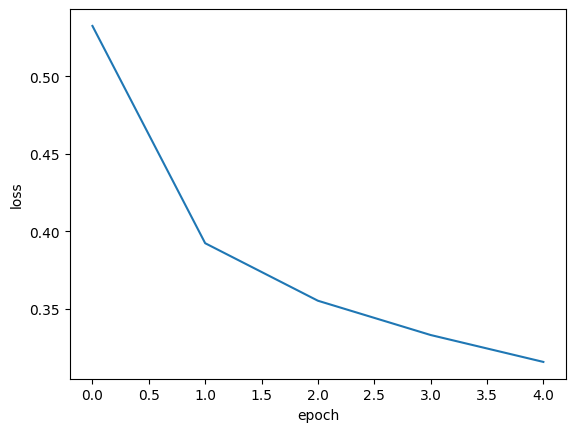

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

파이썬 리스트의 인덱스는 0부터 시작하므로 5개의 에포크가 0에서부터 4까지 x축에 표현된다.   
y축은 계산된 손실 값이다.   
이번에는 정확도를 출력해 본다.

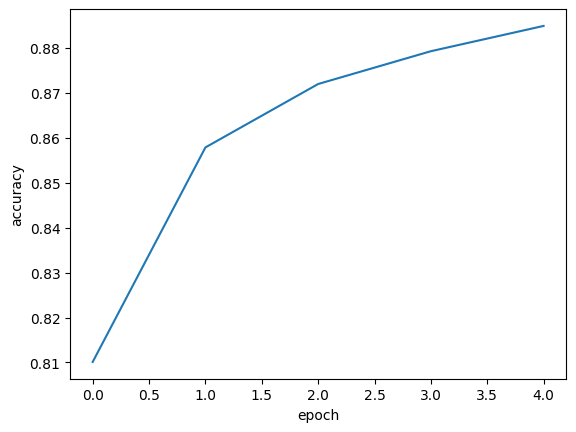

In [9]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

위의 출력 결과에서 보듯이 확실히 에포크마다 손실이 감소하고 정확도가 향상한다.   
그렇다면 에포크를 늘려서 더 훈련해 봐야 하지 않을까?   
계속 손실이 감소하니까 말이다.   
   
이번에는 에포크 횟수를 20으로 늘려서 모델을 훈련하고 손실 그래프를 그려 본다.

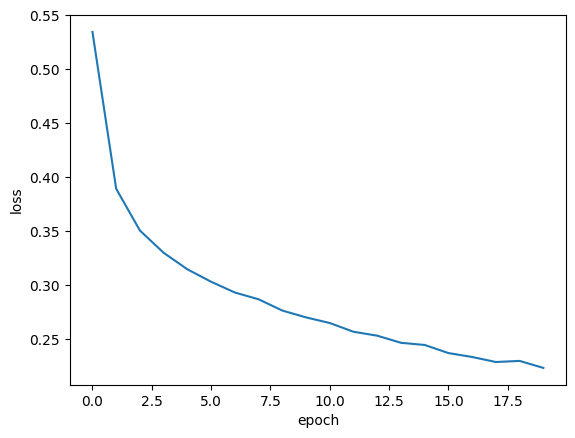

In [10]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

# 에포크 20으로 수정
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

# 손실 결과 그리기
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

예상대로 손실이 잘 감소한다.   
그렇다면 이전보다 더 나은 모델을 훈련한 것일까?   
이전에 학습했던 개념들 중에 놓친 것이 있지 않을까?

# 검증 손실

이전에 확률적 경사 하강법을 사용했을 때, 과대/과소적합과 에포크 사이의 관계를 알아보았다.   
인공 신경망은 모두 일종의 경사 하강법을 사용하기 때문에 동일한 개념이 여기에도 적용된다.   
   
에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라 검증 세트에 대한 점수도 필요하다.   
따라서 앞에서처럼 훈련 세트의 손실만 그려서는 안 된다.   
이전에는 **정확도**를 사용해서 과대/과소적합을 설명했지만, 여기서는 **손실**을 사용하여 과대/과소적합을 다룬다.   
   
인공 신경망 모델이 최적화하는 대상은 정확도가 아니라 손실 함수이다.   
이따금 손실 감소에 비례하여 정확도가 높아지지 않는 경우도 있다.   
따라서 모델이 잘 훈련되었는지 판단하려면 정확도보다는 손실 함수의 값을 확인하는 것이 더 낫다.   
   
에포크마다 검증 손실을 계산하기 위해 케라스 모델의 fit() 메서드에 검증 데이터를 전달할 수 있다.   
다음처럼 validation_data 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달한다.

In [11]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

반환된 history.history 딕셔너리에 어떤 값이 들어 있는지 키를 확인해 본다.

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


검증 세트에 대한 손실은 `val_loss`에 들어 있고, 정확도는 `val_accuracy`에 들어 있을 것이다.   
과대/과소적합 문제를 조사하기 위해 훈련 손실과 검증 손실을 한 그래프에 그려서 비교해 본다.

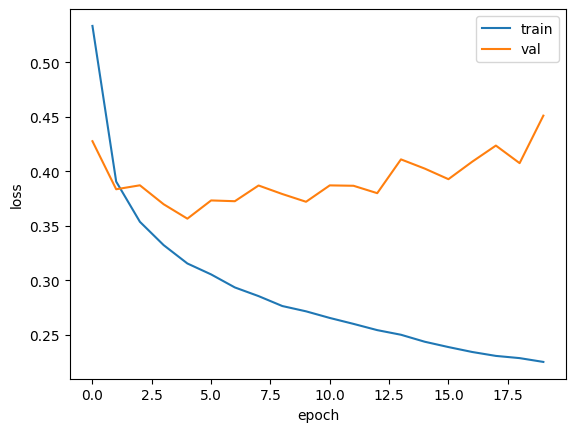

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'val'])

plt.show()

초기에 검증 손실이 감소하다가 다섯 번째 에포크 만에 다시 상승하기 시작한다.   
**훈련 손실은 꾸준히 감소하기 때문에 전형적인 과대적합 모델이 만들어진다.**   
검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것이다.   
   
과대적합을 막기 위해 이전에 배웠던 규제 방식 대신에 신경망에 특화된 규제 방법을 다음 섹션에서 다루어 본다.   
당장은 옵티마이저 하이퍼파라미터를 조정하여 과대적합을 완화시킬 수 있는지 알아본다.   
   
기본 RMSprop 옵티마이저는 많은 문제에서 잘 동작한다.   
만약 이 옵티마이저 대신 다른 옵티마이저를 테스트해 본다면 Adam이 좋은 선택이다.   
Adam은 적응적 학습률을 사용하기 때문에 에포크가 진행되면서 학습률의 크기를 조정할 수 있다.   
Adam 옵티마이저를 적용해 보고 훈련 손실과 검증 손실을 다시 그려 본다.

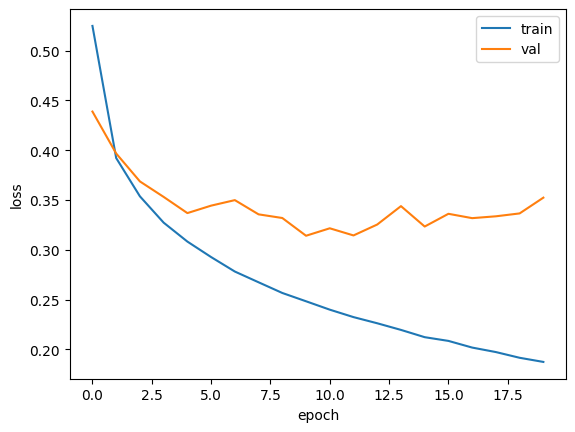

In [14]:
model = model_fn()

# 옵티마이저를 Adam으로 설정
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'val'])

plt.show()

과대적합이 훨씬 줄었다.   
검증 손실 그래프에 여전히 요동이 남아 있지만, 열 번째 에포크까지 전반적인 감소 추세가 이어지고 있다.   
이는 Adam 옵티마이저가 이 데이터셋에 잘 맞는다는 것을 보여 준다.

# 드롭아웃

**드롭아웃(dropout)**은 딥러닝의 아버지로 불리는 제프리 힌턴이 소개했다.   
이 방식은 다음 그림처럼 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(즉 뉴런의 출력을 0으로 만들어) 과대적합을 막는다.

![dropout](https://github.com/kyomin/machineLearning-deepLearning/assets/46395776/837cdb8f-4bed-44b9-a393-1e7af7c726b4)

어떤 샘플을 처리할 때는 은닉층의 두 번째 뉴런이 드롭아웃이 되어 h2 출력이 없다.   
다른 샘플을 처리할 때는 은닉층의 첫 번째 뉴런이 드롭아웃 되어 h1 출력이 없다.   
뉴런은 랜덤하게 드롭아웃 되고 얼마나 많은 뉴런을 드롭할지는 우리가 정해야 할 또 다른 하이퍼파라미터이다.   
   
**드롭아웃이 왜 과대적합을 막을까?**   
**이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고, 모든 입력에 대해 주의를 기울여야 한다.**   
**일부 뉴런의 출력이 없을 수 있다는 것을 감안하면 이 신경망은 더 안정적인 예측을 만들 수 있을 것이다.**   
   
또 다른 해석은 위의 드롭아웃이 적용된 2개의 신경망 그림을 보면 드롭아웃을 적용해 훈련하는 것은 마치 2개의 신경망을 **앙상블** 하는 것처럼 상상할 수 있다.   
이전 트리 앙상블에서 보았듯이 앙상블 학습은 더 좋은 예측 결과를 만들기 위해 여러 개의 모델을 훈련하는 머신러닝 알고리즘이다.   
그리고 이는 과대적합을 막는 좋은 기법이다.   
   
케라스에서는 드롭아웃을 keras.layers 패키지 아래 Dropout 클래스로 제공한다.   
어떤 층의 뒤에 드롭아웃을 두어 이 층의 출력을 랜덤하게 0으로 만드는 것이다.   
드롭아웃이 층처럼 사용되지만 훈련되는 모델 파라미터는 없다.   
   
그럼 앞서 정의한 model_fn() 함수에 드롭아웃 객체를 전달하여 층을 추가해 본다.   
여기에서는 30% 정도를 드롭아웃 한다.   
만들어진 summary() 메서드를 사용해 드롭아웃 층이 잘 추가되었는지 확인해 본다.

In [15]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


출력 결과에서 볼 수 있듯이 은닉층 뒤에 추가된 드롭아웃 층(Dropout)은 훈련되는 모델 파라미터가 없다.   
또한 입력과 출력의 크기가 같다.   
일부 뉴런의 출력을 0으로 만들지만, 전체 출력 배열의 크기를 바꾸지는 않는다.   
   
물론 훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야 한다.   
훈련된 모든 뉴런을 사용해야 올바른 예측을 수행할 수 있다.   
그렇다면 모델을 훈련한 다음 층을 다시 빼야 할까?   
아니다.   
똑똑하게도 텐서플로와 케라스는 모델을 평가와 예측에 사용할 때는 자동으로 드롭아웃을 적용하지 않는다.   
그래서 마음 편하게 검증 점수를 계산할 수 있다.   
이전과 마찬가지로 훈련 손실과 검증 손실의 그래프를 그려 비교해 본다.

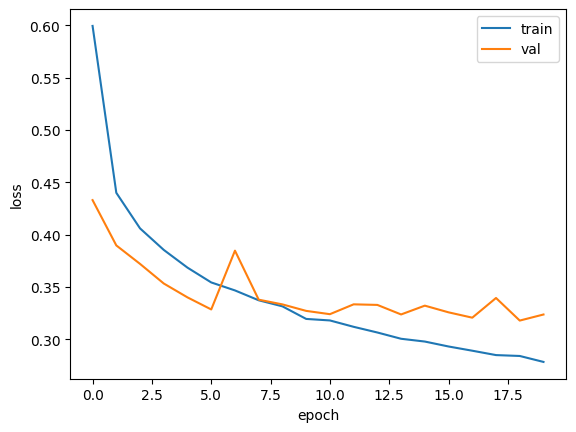

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'val'])

plt.show()

과대적합이 확실히 줄었다.   
열 번째 에포크 정도에서 검증 손실의 감소가 멈추지만 크게 상승하지 않고 어느 정도 유지되고 있다.   
   
이 모델은 20번의 에포크 동안 훈련을 했기 때문에 결국 다소 과대적합 되어 있다.   
그렇다면 과대적합 되지 않은 모델을 얻기 위해 에포크 횟수를 10으로 하고 다시 훈련해야 할 것 같다.

# 모델 저장과 복원

에포크 횟수를 10으로 다시 지정하고 모델을 훈련한다.   
그리고 나중 런칭에 사용하기 위해 이 모델을 저장해야 한다.

In [24]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

케라스 모델은 훈련된 모델의 파라미터를 저장하는 간편한 save_weights() 메서드를 제공한다.   
기본적으로 이 메서드는 텐서플로의 체크포인트 포맷으로 저장하지만, 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

In [25]:
model.save_weights('model-weights.h5')

또한 모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드도 제공한다.   
기본적으로 이 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

In [26]:
model.save('model-whole.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


이 두 파일이 잘 만들어졌는지 확인해 본다.

In [27]:
!ls -al *.h5

-rw-r--r-- 1 root root 333320 Jan 27 14:12 model-weights.h5
-rw-r--r-- 1 root root 981176 Jan 27 14:12 model-whole.h5


두 가지 실험을 해 본다.   
   
첫 번째는 훈련을 하지 않은 새로운 모델을 만들고 `model-weights.h5` 파일에서 훈련된 모델 파라미터를 읽어서 사용한다.   
   
두 번째는 아예 `model-whole.h5` 파일에서 새로운 모델을 만들어 바로 사용한다.   
   
먼저 첫 번째 실험부터 시작한다.

In [28]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

훈련하지 않은 새로운 모델을 만들고 이전에 저장했던 모델 파라미터를 적재했다.   
이 모델의 검증 정확도를 확인해 본다.   
케라스에서 예측을 수행하는 predict() 메서드는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률을 반환한다.   
패션 MNIST 데이터셋이 다중 분류 문제이기 때문이다(이진 분류 문제라면 양성 클래스에 대한 확률 하나만 반환한다).   
   
패션 MNIST 데이터셋에서 덜어낸 검증 세트의 샘플 개수는 12,000개이기 때문에 predict() 메서드는 (12000, 10) 크기의 배열을 반환한다.

![12000x10](https://github.com/kyomin/machineLearning-deepLearning/assets/46395776/b0089ad3-d469-4bc0-ba32-6af2ddf1c40a)

따라서 조금 번거롭지만 10개 확률 중에 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도를 계산해 본다.

In [29]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)

print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 1ms/step
0.8805


모델의 predict() 메서드 결과에서 가장 큰 값을 고르기 위해 넘파이 argmax() 함수를 사용했다.   
이 함수는 배열에서 가장 큰 값의 인덱스를 반환한다.   
예를 들어 배열의 첫 번째 원소가 가장 큰 값일 경우 0을 반환한다.   
다행히 우리가 준비한 타깃값도 0부터 시작하기 때문에 비교하기 좋다.   
   
argmax() 함수의 axis=-1은 배열의 마지막 차원을 따라 최댓값을 고른다.   
검증 세트는 2차원 배열이기 때문에 마지막 차원은 1이 된다.   
간단한 예를 그려 보면 쉽게 이해할 수 있다.

![axis](https://github.com/kyomin/machineLearning-deepLearning/assets/46395776/1c90bb72-aad6-4184-9b7e-154076fde5e0)

axis=1이면 열을 따라 각 행의 최댓값의 인덱스를 선택하고,   
axis=0이면 행을 따라 각 열의 최댓값의 인덱스를 선택한다.   
   
그다음 라인은 argmax()로 고른 인덱스(val_labels)와 타깃(val_target)을 비교한다.   
두 배열에서 각 위치의 값이 값으면 1이되고, 다르면 0이 된다.   
이를 평균하면 정확도가 된다.   
   
이번에는 모델 전체를 파일에서 읽은 다음 검증 세트의 정확도를 출력해 본다.   
모델이 저장된 파일을 읽을 때는 케라스가 제공하는 load_model() 함수를 사용한다.

In [30]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3297 - accuracy: 0.8805


[0.3297356069087982, 0.8805000185966492]

같은 모델을 저장하고 다시 불러들였기 때문에 위와 동일한 정확도를 얻었다.   
   
그런데 이 과정을 돌이켜 보면 20번의 에포크 동안 모델을 훈련하여 검증 점수가 상승하는 지점을 확인했다.   
그다음 모델을 과대적합 되지 않는 에포크만큼(10만큼) 다시 훈련했다.   
모델을 두 번씩 훈련하지 않고 한 번에 끝낼 수는 없을까?   
드디어 케라스의 콜백을 사용할 차례이다.

# 콜백

**콜백(callback)**은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스들이다.   
fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용한다.   
여기서 사용할 ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장한다.   
`save_best_only=True` 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다.   
저장될 파일 이름을 `best-model.h5`로 지정하여 콜백을 적용해 본다.

In [32]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'best-model.h5',
    save_best_only=True
)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb]
        )

model_fn() 함수로 모델을 만들고 compile() 메서드를 호출하는 것은 이전과 동일하다.   
ModelCheckpoint 클래스의 객체 checkpoint_cb를 만든 후 fit() 메서드의 callbacks 매개변수에 리스트로 감싸서 전달한다.   
**모델이 훈련한 후에 best-model.h5에 최상의 검증 점수를 낸 모델이 저장된다.**   
이 모델을 load_model() 함수로 다시 읽어서 예측을 수행해 본다.

In [33]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3154 - accuracy: 0.8871


[0.3154032826423645, 0.8870833516120911]

훨씬 편하다.   
ModelCheckpoint 콜백이 가장 낮은 검증 점수의 모델을 자동으로 저장해 주었다.   
하지만 여전히 20번의 에포크 동안 훈련을 하고 있다.   
사실 검증 점수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없다.   
이때 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있다.   
이렇게 과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 **조기 종료(early stopping)**라고 부르며, 딥러닝 분야에서 널리 사용한다.   
   
조기 종료는 훈련 에포크 횟수를 제한하는 역할이지만, 모델이 과대적합되는 것을 막아 주기 때문에 규제 방법 중 하나로 생각할 수도 있다.   
   
케라스에는 조기 종료를 위한 EarlyStopping 콜백을 제공한다.   
이 콜백의 patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수를 지정한다.   
예를 들어 다음 코드에서처럼 patience=2로 지정하면 2번 연속 검증 점수가 향상되지 않으면 훈련을 중지한다.   
또한 restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다.   
   
EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다.   
또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.   
   
이 두 콜백을 함께 사용해 본다.

In [34]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'best-model.h5',
    save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=2,
    restore_best_weights=True
)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb]
                  )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


EarlyStopping 콜백을 추가한 것 외에는 이전과 동일하다.   
fit() 메서드의 callbacks 매개변수에 2개의 콜백을 리스트로 전달한 것을 눈여겨 본다.   
훈련을 마치고 나면 몇 번째 에포크에서 훈련이 중지되었는지 early_stopping_cb 객체의 stopped_epoch 속성에서 확인할 수 있다.

In [35]:
print(early_stopping_cb.stopped_epoch)

13


훈련 손실과 검증 손실을 출력해서 확인해 본다.

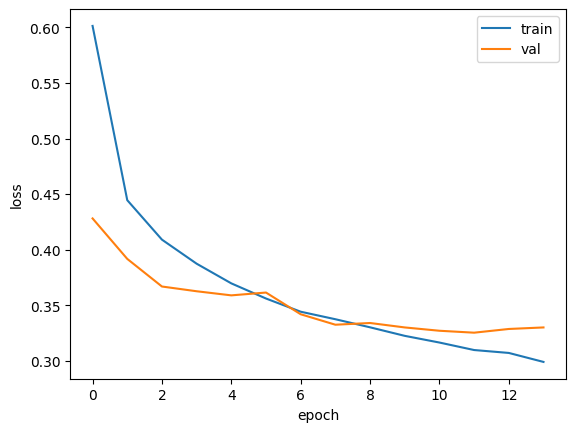

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'val'])

plt.show()

11의 위치(열두 번째) 에포크에서 가장 낮은 손실을 기록했고, 13의 위치(열네 번째) 에포크에서 훈련이 중지되었다(11부터 손실이 2번 이상 연속으로 감소하지 않았으므로).   
조기 종료 기법을 사용하면 안심하고 에포크 횟수를 크게 지정해도 괜찮다.   
컴퓨터 자원과 시간을 아낄 수 있고 ModelCheckpoint 콜백과 함께 사용하면 최상의 모델을 자동으로 저장해 주므로 편리하다.   
마지막으로 조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능을 확인해 본다.

In [37]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3253 - accuracy: 0.8827


[0.3253173232078552, 0.8826666474342346]